In [1]:
import os 
import random
import cv2, matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from sklearn.manifold import TSNE
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import Model

from scipy.spatial.distance import cdist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tqdm

import warnings
from sklearn.neighbors import NearestNeighbors
import math
warnings.filterwarnings("ignore", category=FutureWarning)
tf.keras.backend.clear_session()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.style.use('ggplot')

In [2]:
DATA_DIR = os.path.join(os.path.dirname( os.getcwd()), 'data')
TRIPLET_NAME = 'triplet.csv'
FINAL_DF = 'final_df.csv'
EMBEDDING_NAME = 'image_embedding.pkl'
TSNE_FEATURE_FILE = 'tsne_results.csv'
PATH_TO_TRIPLET_FILE =  os.path.join(DATA_DIR, TRIPLET_NAME)
FINAL_DF_FILE =  os.path.join(DATA_DIR, FINAL_DF)
PATH_TO_IMAGE_EMBEDDING =  os.path.join(DATA_DIR, EMBEDDING_NAME)
PATH_TO_TSNE_RESULTS =  os.path.join(DATA_DIR, TSNE_FEATURE_FILE)

TARGET_SHAPE = (224, 224)
BATCH_SIZE_INFERENCE = 128

raw_df = pd.read_csv(FINAL_DF_FILE)
with open(PATH_TO_IMAGE_EMBEDDING, "rb") as input_file:
    df_embs = pickle.load(input_file)

In [3]:
def plot_embedding(df: pd.DataFrame, col_name: str):
    plt.figure(figsize=(16,10))
    g=sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=col_name,
                data=df,
                legend="full",
                alpha=0.8)
    g.legend(loc='center left', bbox_to_anchor=(1., 0.45), ncol=1)
    g.set(title=f'Image embeddings for {col_name}')

def knn_predict_embeddings(embeddings,metric='minkowski', n_neighbors = 300):
    BATCH_SIZE = 1024 * 4
    n_texts = embeddings.shape[0]
    n_batches = math.ceil(n_texts / BATCH_SIZE)
    knn_model = NearestNeighbors(n_neighbors = n_neighbors, metric=metric)
    knn_model.fit(embeddings)
    embed_distances = np.zeros((n_texts, n_neighbors))
    embed_indices = np.zeros((n_texts, n_neighbors))
    embed_distances, embed_indices = knn_model.kneighbors(embeddings)
    return embed_distances, embed_indices



# def display_images(data_df, rec_list_idx, random=False, rows=5, cols=5):
#    iter_temp=0
#    for k in range(rows):
#        plt.figure(figsize=(20,5))
#        for j in range(cols):
#            img_ret = data_df.iloc[rec_list_idx[iter_temp]]['image_path']
#            img = cv2.imread(img_ret)
#            plt.subplot(1,cols,j+1)
#            plt.title(f'Recommendation {iter_temp+1}')
#            plt.axis('off')
#            plt.imshow(img)
#            iter_temp += 1
#        plt.show()

In [17]:
def display_images(data_df, rec_list_idx, random=False, rows=10, cols=5):
    iter_temp=0
    for k in range(rows):
        plt.figure(figsize=(20,5))
        for j in range(cols):
            img_ret = data_df.iloc[int(rec_list_idx[iter_temp])]['image_path']
            # img = tf.keras.preprocessing.image.load_img(img_ret, target_size=(224,224))
            img = cv2.imread(img_ret)
            plt.subplot(1,cols,j+1)
            plt.title(f'Recommendation {iter_temp+1}: {data_df.iloc[int(rec_list_idx[iter_temp])].product_type}', fontsize=11)
            plt.axis('off')
            plt.imshow(img)
            iter_temp += 1
        plt.show() 

In [ ]:
%%time

tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(df_embs)

In [745]:
raw_df['tsne-2d-one'] = tsne_results[:,0]
raw_df['tsne-2d-two'] = tsne_results[:,1]
raw_df.to_csv(PATH_TO_TSNE_RESULTS, index=False)

In [746]:
raw_df = pd.read_csv(PATH_TO_TSNE_RESULTS)

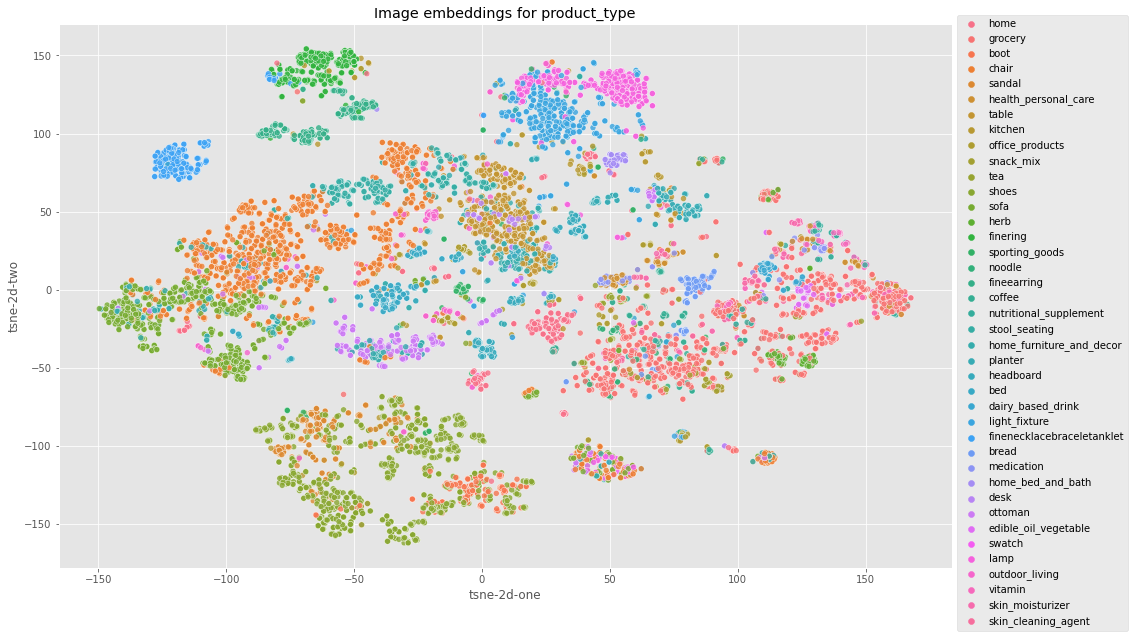

In [747]:
plot_embedding(raw_df, col_name='product_type')

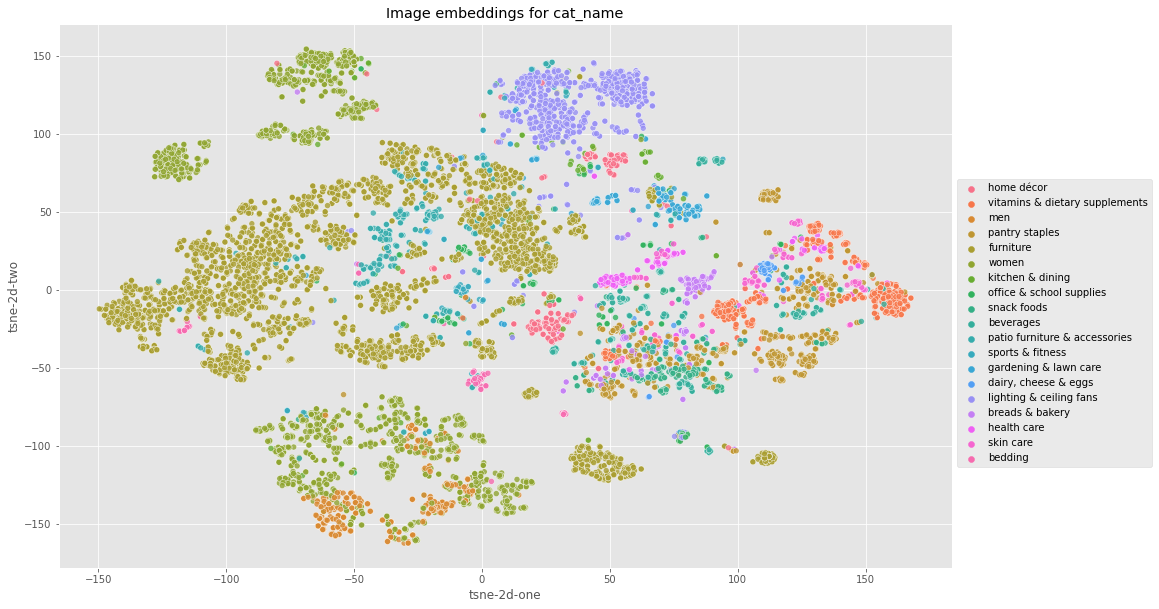

In [748]:
plot_embedding(raw_df, col_name='cat_name')

In [19]:
image_distances, image_indices = knn_predict_embeddings(df_embs, metric='cosine')

In [4]:
class_map = {}
num_classes = len(np.unique(raw_df['cat_name']))

for i, val in enumerate(raw_df['cat_name'].unique()):
    class_map[i] = val
num_classes  = len(class_map.keys())
class_map

{0: 'home décor',
 1: 'vitamins & dietary supplements',
 2: 'men',
 3: 'pantry staples',
 4: 'furniture',
 5: 'women',
 6: 'kitchen & dining',
 7: 'office & school supplies',
 8: 'snack foods',
 9: 'beverages',
 10: 'patio furniture & accessories',
 11: 'sports & fitness',
 12: 'gardening & lawn care',
 13: 'dairy, cheese & eggs',
 14: 'lighting & ceiling fans',
 15: 'breads & bakery',
 16: 'health care',
 17: 'skin care',
 18: 'bedding'}

In [558]:

base_cnn = tf.keras.applications.EfficientNetB0(
    weights="imagenet", input_shape=TARGET_SHAPE + (3,), include_top=False, pooling='avg',
)

x = base_cnn.output
x = Lambda(lambda  x: K.l2_normalize(x,axis=-1))(x)
embedding_model_1 = Model(base_cnn.input, x, name="embedding")

test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_dataframe(
        raw_df,
        x_col='image_path',
        y_col='product_type',
        directory=None,
        target_size=TARGET_SHAPE,
        batch_size=BATCH_SIZE_INFERENCE,
        class_mode='categorical',
        shuffle = False
)
df_embs_1 = embedding_model_1.predict(validation_generator, verbose=1)

Found 10402 validated image filenames belonging to 40 classes.
82/82 [==============================] - 314s 4s/step


In [ ]:
class_names = list(class_map.values())
dist_marix = np.zeros((num_classes,num_classes))
for i in range(len(class_names)):
    j = i+1
    dist_marix[i,i] = 0
    while j < len(class_names):
        embed_i = df_embs_1[raw_df['cat_name'] == class_map[i]]
        embed_j = df_embs_1[raw_df['cat_name'] == class_map[j]]
        dist = cdist(embed_i, embed_j).mean(axis=0).mean(axis=0)
        dist_marix[i,j] = dist
        j +=1
X_1 = dist_marix + dist_marix.T - np.diag(np.diag(dist_marix))

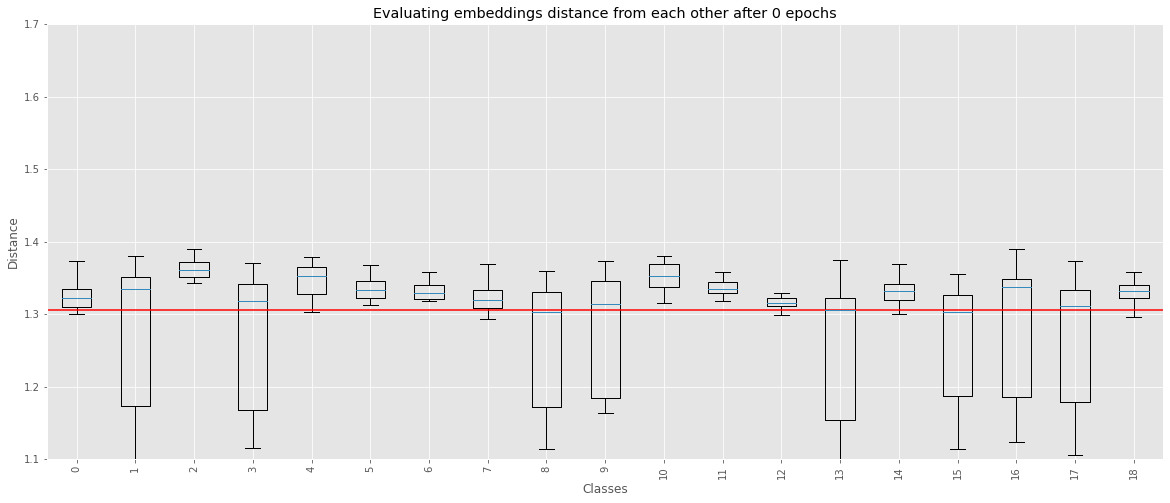

In [560]:
num_classes = len(np.unique(raw_df['cat_name']))
interdist = X_1
data_1 = []
for i in range(num_classes):
    data_1.append(np.delete(interdist[i,:],[i]))
overall_mean_1 = np.mean([val.mean() for val in data_1])
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(0))
ax.set_ylim([1.1,1.7])
plt.xlabel('Classes')
plt.ylabel('Distance')
ax.boxplot(data_1,showfliers=False,showbox=True)
locs, labels = plt.xticks()
plt.xticks(locs,np.arange(num_classes), rotation=90)
plt.axhline(y=overall_mean_1, color='r', linestyle='-')
plt.show()

In [561]:
dist_marix = np.zeros((num_classes,num_classes))
for i in range(len(class_map.keys())):
    j = i+1
    dist_marix[i,i] = 0
    while j < len(class_map.keys()):
        embed_i = df_embs[raw_df['cat_name'] == class_map[i]]
        embed_j = df_embs[raw_df['cat_name'] == class_map[j]]
        dist = np.mean(cdist(embed_i, embed_j).mean(axis=0))
        dist_marix[i,j] = dist
        j +=1
X = dist_marix + dist_marix.T - np.diag(np.diag(dist_marix))

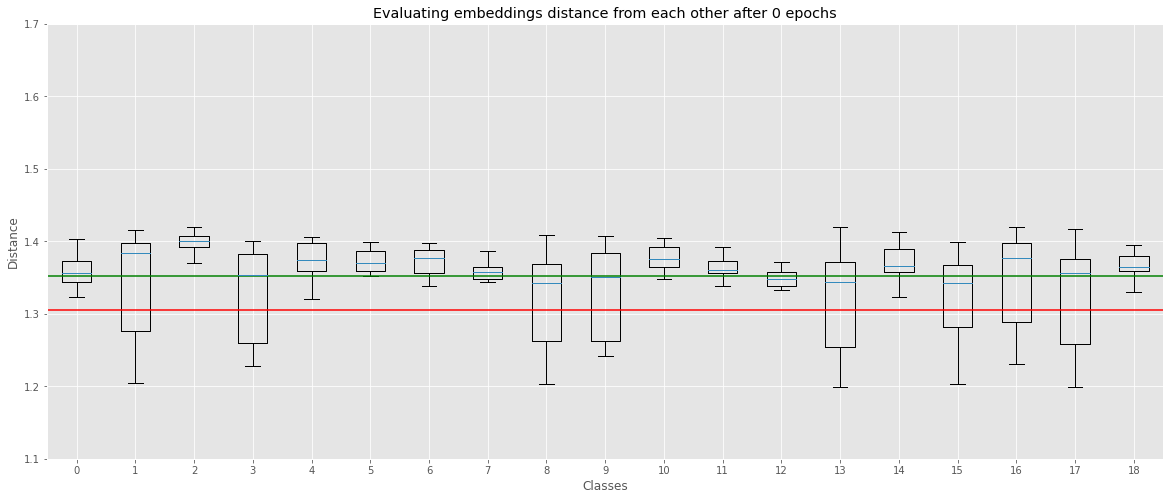

In [562]:
num_classes = len(np.unique(raw_df['cat_name']))
interdist = X
data = []
for i in range(num_classes):
    data.append(np.delete(interdist[i,:],[i]))
overall_mean = np.mean([val.mean() for val in data])
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(0))
ax.set_ylim([1.1,1.7])
plt.xlabel('Classes')
plt.ylabel('Distance')
ax.boxplot(data,showfliers=False,showbox=True)
locs, labels = plt.xticks()
plt.xticks(locs,np.arange(num_classes))
plt.axhline(y=overall_mean_1, color='r', linestyle='-')
plt.axhline(y=overall_mean, color='g', linestyle='-')
plt.show()
plt.show()

In [22]:
from sklearn.metrics.pairwise import cosine_similarity


In [23]:
image_similarity_scores = np.zeros((raw_df.shape[0],raw_df.shape[0]))
image_similarity_scores = cosine_similarity(df_embs,df_embs)
# image_similarity_scores_1 = np.zeros((raw_df.shape[0],raw_df.shape[0]))
# image_similarity_scores_1 = cosine_similarity(df_embs_1,df_embs_1)

In [24]:
TEXT_SIMILARITY_SCORE_PATH = os.path.join(DATA_DIR, "text_embedding.pkl")
with open(TEXT_SIMILARITY_SCORE_PATH, "rb") as input_file:
    df_embs_text = pickle.load(input_file)
text_similarity_scores = np.zeros((raw_df.shape[0],raw_df.shape[0]))
text_similarity_scores = cosine_similarity(df_embs_text,df_embs_text)

In [43]:
raw_df[raw_df['item_id'] == 'B085GXH8YR']

main_image_id                                      item_keywords  \
52   81uxsQ3y7sL  farmhouse**small**euro**swivel**motion**ottoma...   

   product_type                                          item_name  \
52        chair  Amazon Brand - Stone & Beam Cambridge Upholste...   

                                         bullet_point  \
52  Light-blue upholstery offers a pop of color, m...   

                                            node_name   cat_name     item_id  \
52  /categories/furniture/living room furniture/ch...  furniture  B085GXH8YR   

                                       node_name_type    cat_prod_name  \
52  /Categories/Furniture/Living Room Furniture/Ch...  Furniture_CHAIR   

                                           image_path  \
52  C:\Purdue\industry_practicum\e-rec\data\image_...   

                                          pos_triplet  \
52  C:\Purdue\industry_practicum\e-rec\data\image_...   

                                          neg_triplet  
52  C:\Purdue\industry_practicum\e-rec\data\image_...

In [1]:
indices_data = pd.Series(range(len(raw_df)), index=raw_df.index)
top_k = 50
# B06XTFJ5CL - 509
# B078GV4F8H - 3637
# B085GXH8YR - 52
# 57, 130, 1900, 4000, 570, 870
# 57, 1900, 4000, 570, 6678, 6654, 7732, 8890, 8899
# 8899, 509, 3627 
sim_index = raw_df[raw_df['item_id'] == 'B06XTFJ5CL'].index.values[0]
sim_index = 509
sim_scores_image = list(enumerate(image_similarity_scores[sim_index]))
sim_scores_image = sorted(sim_scores_image, key=lambda x: x[1], reverse=True)
sim_scores_image = sim_scores_image[1:top_k+1]
rec_idx_image = [i[0] for i in sim_scores_image]
rec_scores_image = [i[1] for i in sim_scores_image]

NameError: name 'pd' is not defined

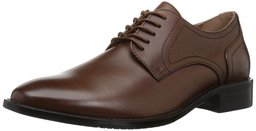

In [ ]:
tf.keras.preprocessing.image.load_img(raw_df.iloc[sim_index]['image_path'])

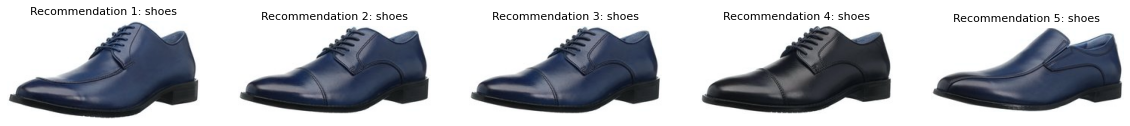

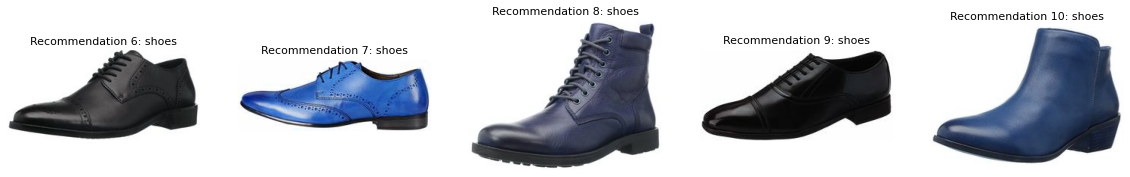

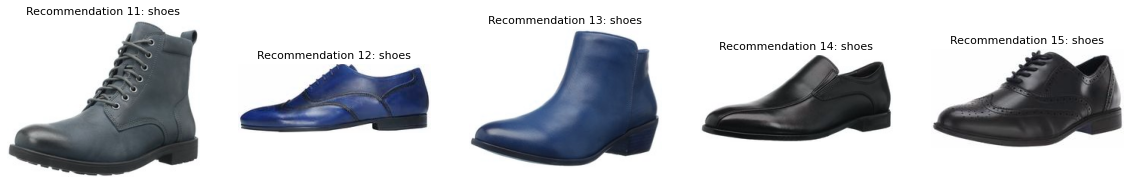

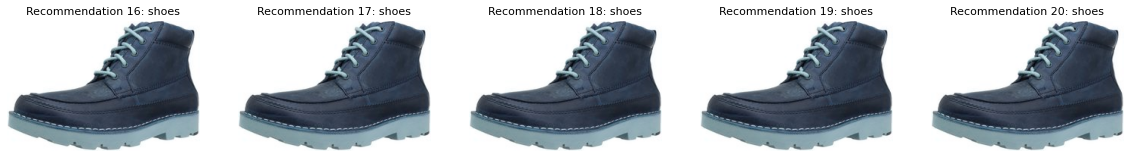

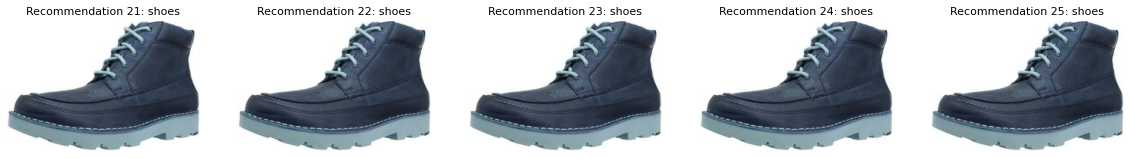

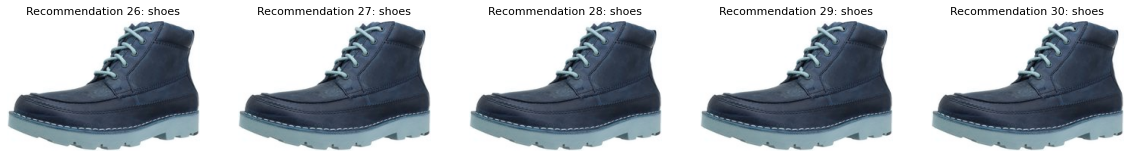

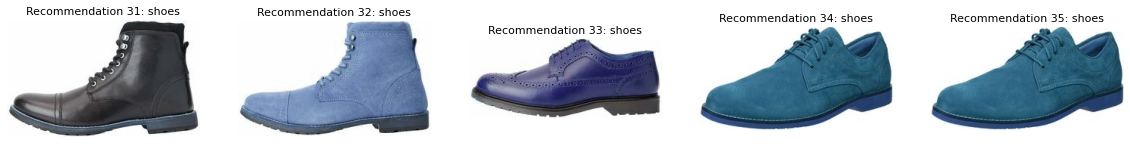

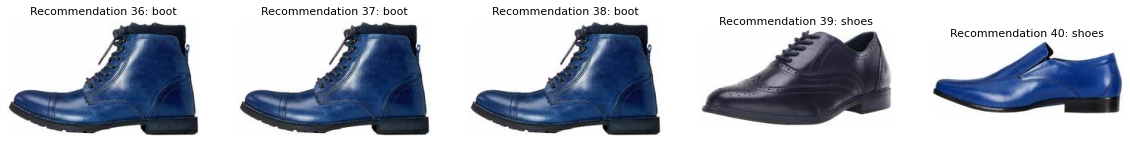

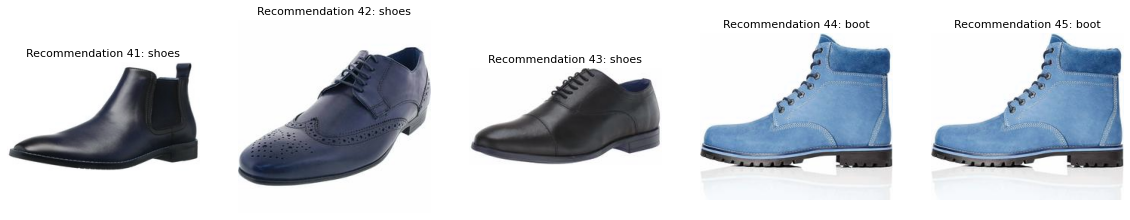

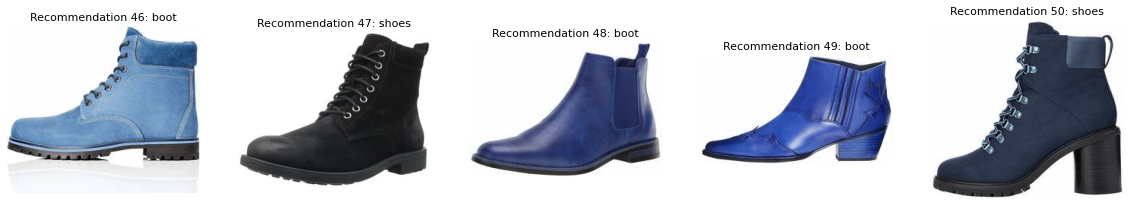

In [100]:
display_images(raw_df, rec_idx_image, random=True)

In [101]:
sim_scores_text = list(enumerate(text_similarity_scores[sim_index]))
sim_scores_text = sorted(sim_scores_text, key=lambda x: x[1], reverse=True)
sim_scores_text = sim_scores_text[1:top_k+1]
rec_idx_text = [i[0] for i in sim_scores_text]
rec_scores_text = [i[1] for i in sim_scores_text]

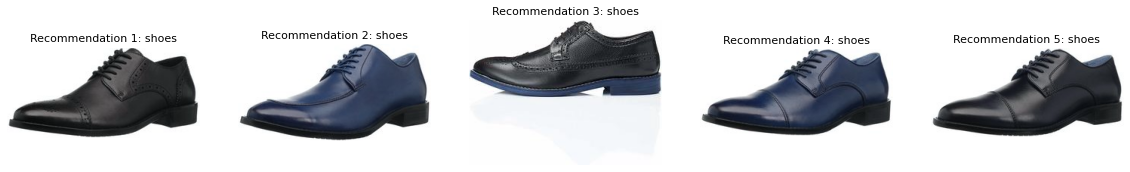

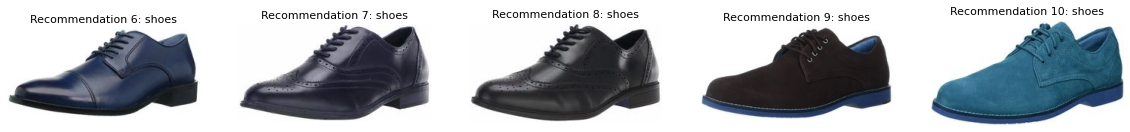

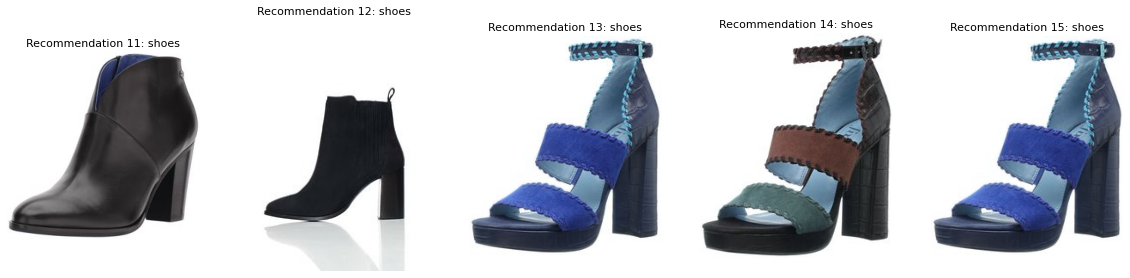

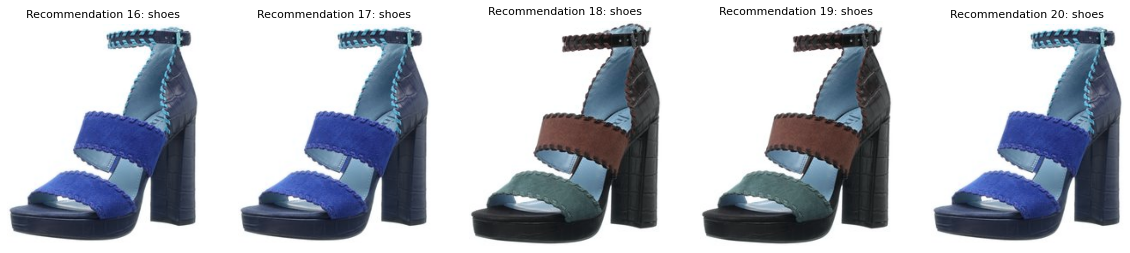

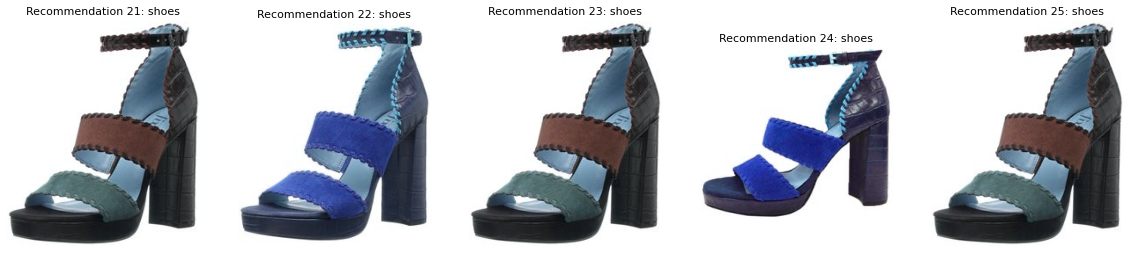

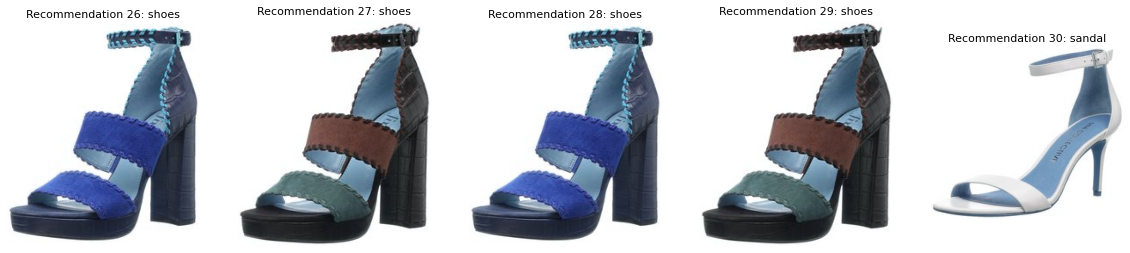

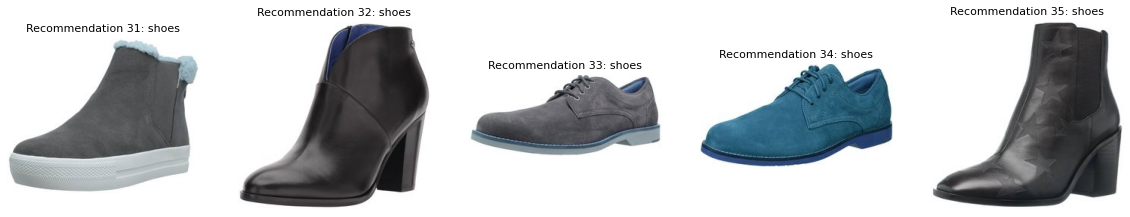

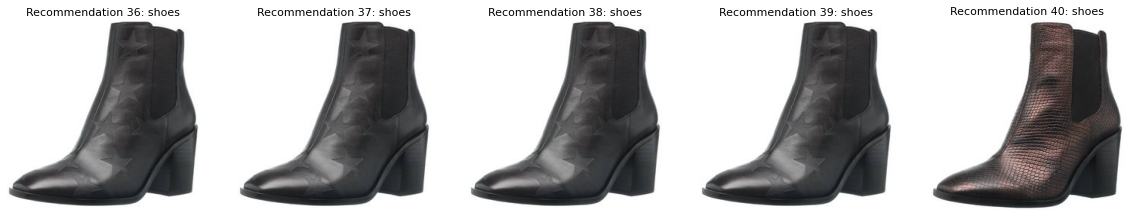

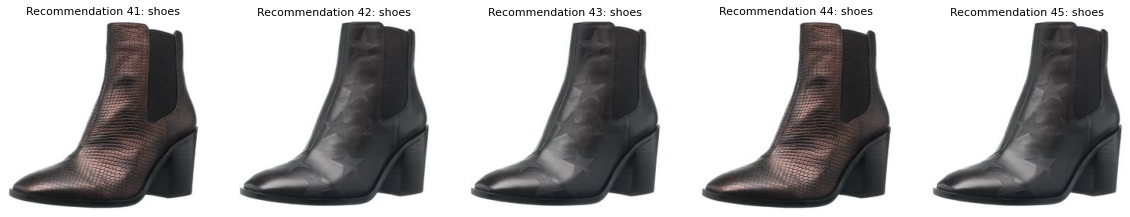

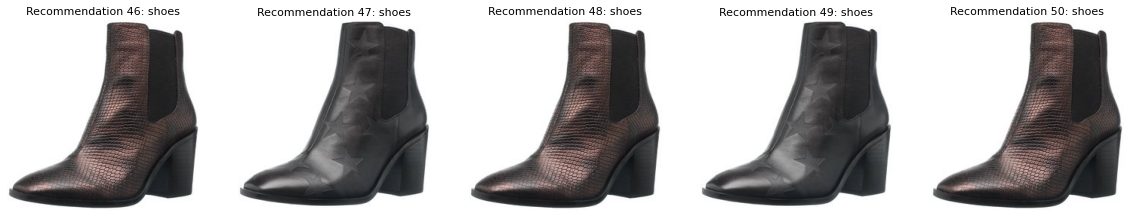

In [102]:
display_images(raw_df, rec_idx_text, random=True)

## Similar Category mapping

In [571]:
col_name = 'product_type'
class_map = {}
num_classes = len(np.unique(raw_df[col_name]))
for i, val in enumerate(raw_df[col_name].unique()):
    class_map[i] = val
num_classes = len(class_map.keys())
num_classes

40

In [587]:
dist_matrix = np.zeros((num_classes,num_classes))
sim_matrix = np.zeros((num_classes,num_classes))

for i in tqdm.tqdm(range(len(class_map.keys()))):
    j = i+1
    dist_matrix[i,i] = 0
    while j < len(class_map.keys()):
        embed_i = df_embs[raw_df[col_name] == class_map[i]]
        embed_j = df_embs[raw_df[col_name] == class_map[j]]
        cos_sim = cosine_similarity(embed_i,embed_j).mean(axis=0).mean(axis=0)
        dist = cdist(embed_i, embed_j).mean(axis=0).mean(axis=0)
        sim_matrix[i,j] = cos_sim 
        dist_matrix[i,j] = dist 
        j +=1
full_dist = dist_matrix + dist_matrix.T - np.diag(np.diag(dist_matrix))
full_cosine = sim_matrix + sim_matrix.T - np.diag(np.diag(sim_matrix))

100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


In [751]:
THRESHOLD = 0.28
misses = 0
mapping_dict = {}
for k,v in class_map.items():
    neigh = []
    similarty_list = list(np.where(full_cosine[k]>THRESHOLD)[0])
    if not similarty_list:
        misses +=1
    else:
        for val in similarty_list:
            neigh.append(class_map.get(val))
    mapping_dict[v] = neigh
misses

22

Text(0.5, 0, 'Closest neighbors')

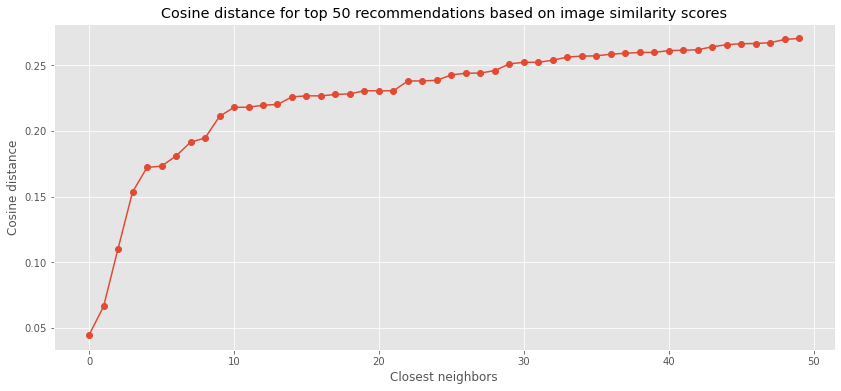

In [603]:
dist_list = [1-val for val in rec_scores_image]
plt.figure(figsize=(14,6))
plt.plot(np.arange(len(dist_list)), dist_list, 'o-')
plt.title(f'Cosine distance for top {len(dist_list)} recommendations based on image similarity scores')
plt.ylabel('Cosine distance')
plt.xlabel('Closest neighbors')

Text(0.5, 0, 'Closest neighbors')

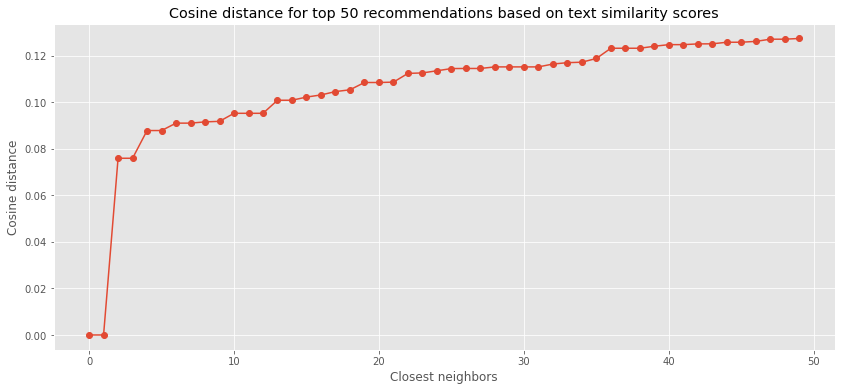

In [604]:
dist_list = [1-val for val in rec_scores_text]
plt.figure(figsize=(14,6))
plt.plot(np.arange(len(dist_list)), dist_list, 'o-')
plt.title(f'Cosine distance for top {len(dist_list)} recommendations based on text similarity scores')
plt.ylabel('Cosine distance')
plt.xlabel('Closest neighbors')

Text(0.5, 0, 'Closest neighbors')

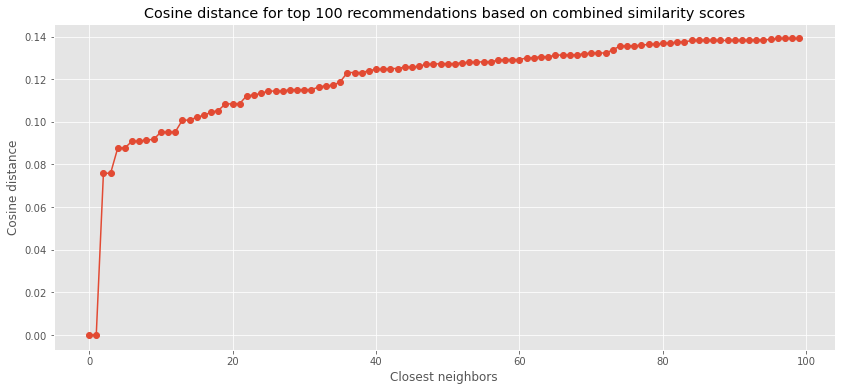

In [605]:
dist_list = [1-val for val in rec_scores_comb]
plt.figure(figsize=(14,6))
plt.plot(np.arange(len(dist_list)), dist_list, 'o-')
plt.title(f'Cosine distance for top {len(dist_list)} recommendations based on combined similarity scores')
plt.ylabel('Cosine distance')
plt.xlabel('Closest neighbors')

In [606]:
def get_map_n(prod_index, n, rec_index, df, product_col='product_type') -> float:
    j=0
    query_product_type = df.iloc[prod_index][product_col]
    expected_product_type = mapping_dict[query_product_type]
    for i in rec_index[:n]:
        rec_product_type = df.iloc[i][product_col]
        if rec_product_type == query_product_type:
             j+=1
        elif rec_product_type in expected_product_type:
            j+=0.5
        else:
            continue
    return j/n

## Mean Average Precision for Image Recommendations

In [742]:
# map_range = [5,10,20,50,100]
# map_scores_images = []
# for map_threshold in (map_range):
#     map_temp = []
#     for index in (raw_df.index):
#         rec_idx_final, _ = get_rec(similarity_score=image_similarity_scores, sim_index=index)
#         map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_final, df=raw_df, product_col='product_type')
#         map_temp.append(map_val)
#     map_scores_images.append(np.mean(map_temp))
#     print(f'Precision in Top {map_threshold} recommendations:', np.mean(map_temp))
# np.mean(map_scores_images)

In [743]:
# comparision_df_10 = pd.DataFrame({
#     'model': ['image', 'text', 'image_siamese'],
#     'grocery': [0.71, 0.758, 0.709],
#     'chair': [0.808, 0.81, 0.805],
#     'shoes': [0.905, 0.719, 0.894],
#     'sofa': [0.889, 0.873, 0.887],
#     # 'home_furniture_and_decor': [0.489, 0.541, 0.482],
#     'sandal': [0.764, 0.6, 0.758],
#     'boot': [0.68, 0.391, 0.688],
#     'fineearring': [0.957, 0.902, 0.945],
#     'bed': [0.931, 0.918, 0.925],
#     'all': [0.769, 0.774, 0.762]
# })
# comparision_df_10

In [718]:
raw_df.product_type.unique()

array(['home', 'grocery', 'boot', 'chair', 'sandal',
       'health_personal_care', 'table', 'kitchen', 'office_products',
       'snack_mix', 'tea', 'shoes', 'sofa', 'herb', 'finering',
       'sporting_goods', 'noodle', 'fineearring', 'coffee',
       'nutritional_supplement', 'stool_seating',
       'home_furniture_and_decor', 'planter', 'headboard', 'bed',
       'dairy_based_drink', 'light_fixture', 'finenecklacebraceletanklet',
       'bread', 'medication', 'home_bed_and_bath', 'desk', 'ottoman',
       'edible_oil_vegetable', 'swatch', 'lamp', 'outdoor_living',
       'vitamin', 'skin_moisturizer', 'skin_cleaning_agent'], dtype=object)

In [749]:
comparision_df_5 = pd.DataFrame({
    'model': ['text', 'image', 'combined'],
    'grocery': [0.781, 0.742, 0.789],
    'coffee': [0.713, 0.612, 0.699],
    'nutritional_supplement': [0.584, 0.494, 0.54],
    'chair': [0.825, 0.838, 0.892],
    'sofa': [0.892, 0.904, 0.934],
    'bed': [0.847, 0.902, 0.911],
    'shoes': [0.734, 0.917, 0.925],
    'sandal': [0.649, 0.813, 0.837],
    'boot': [0.41, 0.73, 0.743],
    'fineearring': [0.934, 0.966, 0.979],
    'finenecklacebraceletanklet': [0.934, 0.966, 0.968],
    'all': [0.801, 0.805, 0.86]
})
comparision_df_5.to_csv('model_compare_category.csv', index=False)

In [750]:
overall_map_df = pd.DataFrame({
    'model': ['text', 'image', 'combined'],
    'map@5': [0.801, 0.805, 0.861],
    'map@10': [0.774, 0.762, 0.827],
    'map@20': [0.745, 0.716, 0.789],
    'map@50': [0.690, 0.647, 0.728],
    'map@100': [0.345, 0.324, 0.674],
})
overall_map_df.to_csv('overall_map_df.csv', index=False)

In [741]:
# text_similarity_scores
# image_similarity_scores
# image_similarity_scores_1
comb_sim_scores = combined_pred(image_similarity_scores, text_similarity_scores, image_weight=0.5)
map_range = [100]
map_scores_images = []
for map_threshold in (map_range):
    map_temp = []
    # temp_df = raw_df[raw_df['product_type'] == 'grocery']
    for index in (raw_df.index):
        # rec_idx_final, _ = get_rec(similarity_score=text_similarity_scores, sim_index=index)
        rec_idx_comb, _ = combined_rec(raw_df, image_similarity_scores, comb_sim_scores, sim_index=index)
        map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_comb, df=raw_df, product_col='product_type')
        # map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_final, df=raw_df, product_col='product_type')
        map_temp.append(map_val)
    map_scores_images.append(np.mean(map_temp))
    print(f'Precision in Top {map_threshold} recommendations:', np.mean(map_temp))
np.round(np.mean(map_scores_images),3)

Precision in Top 100 recommendations: 0.6743544510671025


0.674

In [709]:
map_range = [5,10,20]
map_scores_images = []
for map_threshold in (map_range):
    map_temp = []
    temp_df = raw_df[raw_df['product_type'] == 'boot']
    for index in (temp_df.index):
        rec_idx_final, _ = get_rec(similarity_score=image_similarity_scores, sim_index=index)
        map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_final, df=raw_df, product_col='product_type')
        map_temp.append(map_val)
    map_scores_images.append(np.mean(map_temp))
    print(f'Precision in Top {map_threshold} recommendations:', np.mean(map_temp))
np.mean(map_scores_images)

Precision in Top 5 recommendations: 0.7981132075471697
Precision in Top 10 recommendations: 0.7900943396226414
Precision in Top 20 recommendations: 0.786320754716981


0.791509433962264

In [ ]:
map_range = [5,10,20]
map_scores_text = []
for map_threshold in (map_range):
    map_temp = []
    temp_df = raw_df[raw_df['product_type'] == 'boot']
    for index in (temp_df.index):
        rec_idx_final, _ = get_rec(similarity_score=text_similarity_scores, sim_index=index)
        map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_final, df=raw_df, product_col='product_type')
        map_temp.append(map_val)
    map_scores_text.append(np.mean(map_temp))
    print(f'Precision in Top {map_threshold} recommendations:', np.mean(map_temp))
np.mean(map_scores_text)

Precision in Top 5 recommendations: 0.40963855421686746
Precision in Top 10 recommendations: 0.39096385542168677
Precision in Top 20 recommendations: 0.3635542168674699


0.38805220883534136

In [ ]:
# def optimize_weights(image_weight):
#     top_k=10
#     comb_sim_scores = combined_pred(image_similarity_scores, text_similarity_scores, image_weight=image_weight)
#     map_temp = []
#     for index in raw_df.index:
#         rec_idx_comb, _ = combined_rec(raw_df, image_similarity_scores, comb_sim_scores, sim_index=index)
#         map_val = get_map_n(prod_index=index, n=top_k, rec_index=rec_idx_comb, df=raw_df, product_col='product_type')
#         map_temp.append(map_val)
#     map_score = np.mean(map_temp)
#     return map_score

In [ ]:
# from bayes_opt import BayesianOptimization

# optimizer = BayesianOptimization(
#     optimize_weights,
#     {
#     'image_weight': (0, 1),
#     })
# optimizer.maximize(5, 1)


Text(0.5, 0, 'Number of Recommendations')

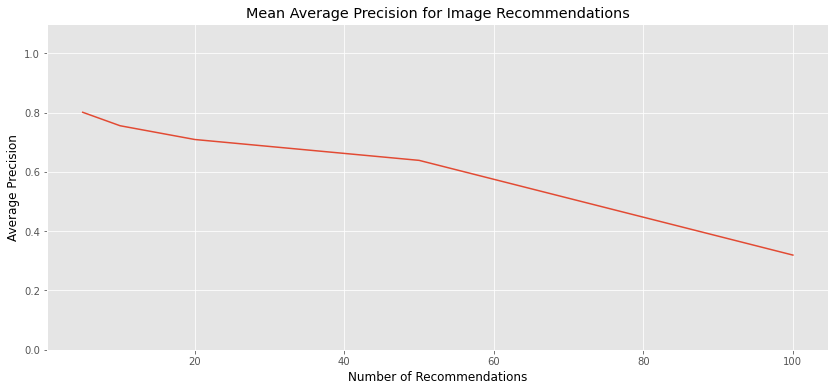

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(map_range, map_scores_images)
plt.ylim((0,1.1))
plt.title(f'Mean Average Precision for Image Recommendations')
plt.ylabel('Average Precision', color='black')
plt.xlabel('Number of Recommendations', color='black')

## Mean Average Precision for Text Recommendations

In [ ]:
map_range = [5,10,20,50,100]
map_scores_text = []
for map_threshold in (map_range):
    map_temp = []
    for index in (raw_df.index):
        rec_idx_final, _ = get_rec(similarity_score=text_similarity_scores, sim_index=index)
        map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_final, df=raw_df, product_col='product_type')
        map_temp.append(map_val)
    map_scores_text.append(np.mean(map_temp))
    print(f'Precision in Top {map_threshold} recommendations:', np.mean(map_temp))
np.mean(map_scores_text)

Precision in Top 5 recommendations: 0.7947894635646993
Precision in Top 10 recommendations: 0.7658383003268602
Precision in Top 20 recommendations: 0.7332412036146895
Precision in Top 50 recommendations: 0.6752259180926745
Precision in Top 100 recommendations: 0.33761295904633726


0.6613415689290522

In [ ]:
map_scores_text

[0.7947894635646993,
 0.7658383003268602,
 0.7332412036146895,
 0.6752259180926745,
 0.33761295904633726]

Text(0.5, 0, 'Number of Recommendations')

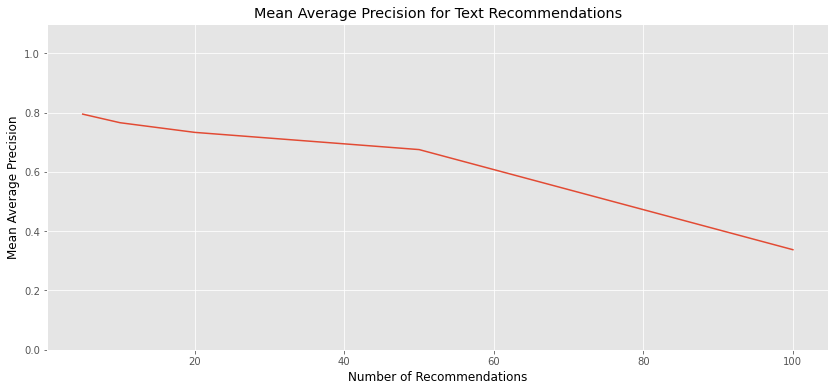

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(map_range, map_scores_text)
plt.ylim((0,1.1))
plt.title(f'Mean Average Precision for Text Recommendations')
plt.ylabel('Mean Average Precision', color='black')
plt.xlabel('Number of Recommendations', color='black')

## Mean Average Precision for Combined Recommendations

In [ ]:
map_range = [5,10,20,50,100]
map_scores_comb = []
for map_threshold in (map_range):
    map_temp = []
    for index in raw_df.index:
        rec_idx_final, _ = combined_rec()
        map_val = get_map_n(prod_index=index, n=map_threshold, rec_index=rec_idx_final, df=raw_df, product_col='cat_name')
        map_temp.append(map_val)
    map_scores_comb.append(np.mean(map_val))
    print(f'Precision in Top {map_threshold} recommendations:', map_val)

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(map_range, map_scores_comb)
plt.ylim((0,1.1))
plt.title(f'Mean Average Precision for Combined Recommendations')
plt.ylabel('Mean Average Precision', color='black')
plt.xlabel('Number of Recommendations', color='black')

In [ ]:
map_range = [5,10,20,50,100]
map_scores = []
for map_threshold in map_range:
    map_val = get_map_n(prod_index=sim_index, n=map_threshold, rec_index=rec_idx_text, df=raw_df, product_col='cat_name')
    map_scores.append(map_val)
    print(f'Precision in Top {map_threshold} recommendations:', map_val)
plt.figure(figsize=(14,6))
plt.plot(map_range, map_scores)
plt.ylim((0,1.1))
plt.title(f'Precision')
plt.ylabel('Precision', color='black')
plt.xlabel('Recommendations', color='black')

In [ ]:
map_range = [5,10,20,50,100]
map_scores = []
for map_threshold in map_range:
    map_val = get_map_n(prod_index=sim_index, n=map_threshold, rec_index=rec_idx_comb, df=raw_df, product_col='cat_name')
    map_scores.append(map_val)
    print(f'Precision in Top {map_threshold} recommendations:', map_val)
plt.figure(figsize=(14,6))
plt.plot(map_range, map_scores)
plt.ylim((0,1.1))
plt.title(f'Precision')
plt.ylabel('Precision', color='black')
plt.xlabel('Recommendations', color='black')